<a href="https://colab.research.google.com/github/FatmaBuseBorlu/DRAMER-Dataset/blob/main/TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from IPython import get_ipython
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from collections import Counter

In [10]:
# Google Drive Bağlantısı (eğer kullanıyorsanız)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Veri setinin bulunduğu dizin
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"

In [12]:
# Veri Artırma: Flip ve Gürültü Ekleme
class CustomRandomFlip:
    def __init__(self, axis):
        self.axis = axis

    def __call__(self, eeg=None, **kwargs):
        if eeg is not None and isinstance(eeg, torch.Tensor):
            if random.random() > 0.5:
                eeg = torch.flip(eeg, dims=(self.axis,))
        return {**kwargs, 'eeg': eeg}

offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor(),
    CustomRandomFlip(axis=2),
    transforms.RandomNoise(std=0.02)
])

# Veri Seti Tanımı
dataset_multi_label = DREAMERDataset(
    io_path='./dreamer_multi_label_data',
    mat_path=dataset_path,
    offline_transform=offline_transform,
    label_transform=transforms.Compose([
        transforms.Select(['valence', 'arousal']),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-27 04:23:31] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_multi_label_data.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_multi_label_data.
[2024-12-27 04:23:31] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  52%|█████▏    | 12/23 [01:22<01:19,  7.19s/it]/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[PROCESS]: 100%|██████████| 23/23 [02:47<00:00,  7.29s/it]
[2024-12-27 04:27:59] I

In [13]:
# Veri setini eğitim ve test için bölme
data_size_multi = len(dataset_multi_label)
train_size_multi = int(0.8 * data_size_multi)
test_size_multi = data_size_multi - train_size_multi
train_dataset_multi, test_dataset_multi = random_split(dataset_multi_label, [train_size_multi, test_size_multi])

In [14]:
# Veri yükleyiciler
train_loader_multi = DataLoader(train_dataset_multi, batch_size=32, shuffle=True)
test_loader_multi = DataLoader(test_dataset_multi, batch_size=32, shuffle=False)

In [15]:
# Sınıf Ağırlıklarını Hesaplama
def calculate_class_weights(dataset):
    valence_labels = []
    arousal_labels = []

    for _, label in dataset:
        valence_labels.append(label[0])
        arousal_labels.append(label[1])

    valence_counts = Counter(valence_labels)
    arousal_counts = Counter(arousal_labels)

    total_valence = sum(valence_counts.values())
    total_arousal = sum(arousal_counts.values())

    valence_weights = {cls: total_valence / count for cls, count in valence_counts.items()}
    arousal_weights = {cls: total_arousal / count for cls, count in arousal_counts.items()}

    valence_weight_tensor = torch.tensor(
        [valence_weights[cls] for cls in sorted(valence_weights.keys())]
    ).to(device)
    arousal_weight_tensor = torch.tensor(
        [arousal_weights[cls] for cls in sorted(arousal_weights.keys())]
    ).to(device)

    return valence_weight_tensor, arousal_weight_tensor

# Sınıf ağırlıkları ve cihaz belirleme
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valence_weight_tensor, arousal_weight_tensor = calculate_class_weights(train_dataset_multi)
valence_criterion = nn.CrossEntropyLoss(weight=valence_weight_tensor).to(device)
arousal_criterion = nn.CrossEntropyLoss(weight=arousal_weight_tensor).to(device)

In [17]:
# TCN Modeli
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout):
        super(TemporalBlock, self).__init__()
        # Padding, giriş ve çıkış boyutlarının eşleşmesi için otomatik hesaplanır
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)

        # Residual bağlantı uyumu
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))  # İlk Conv1d işlemi
        y = self.dropout1(y)
        y = F.relu(self.bn2(self.conv2(y)))  # İkinci Conv1d işlemi
        y = self.dropout2(y)

        # Giriş ve çıkış boyutları uyumlu değilse dönüştür
        if self.downsample is not None:
            x = self.downsample(x)

        # Residual bağlantı - boyutları kontrol et ve gerekirse kırp
        diff = x.shape[2] - y.shape[2]

        if diff > 0:  # x daha uzunsa, x'i kırp
            x = x[:, :, :y.shape[2]]
        elif diff < 0:  # y daha uzunsa, y'yi kırp
            y = y[:, :, :x.shape[2]]

        return F.relu(x + y)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.3):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class EEG_MultiLabel_Model_TCN(nn.Module):
    def __init__(self, input_channels, num_classes_valence, num_classes_arousal, dropout_rate=0.3):
        super(EEG_MultiLabel_Model_TCN, self).__init__()
        self.tcn = TCN(num_inputs=input_channels, num_channels=[32, 64, 128, 256], kernel_size=3, dropout=dropout_rate)
        self.fc_valence = nn.Linear(256, num_classes_valence)
        self.fc_arousal = nn.Linear(256, num_classes_arousal)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)  # (B, C, T)
        x = self.tcn(x)
        x = torch.mean(x, dim=-1)  # Global Average Pooling
        valence_output = self.fc_valence(x)
        arousal_output = self.fc_arousal(x)
        return valence_output, arousal_output

# Model ve optimizer tanımı
model_tcn = EEG_MultiLabel_Model_TCN(input_channels=128, num_classes_valence=2, num_classes_arousal=2, dropout_rate=0.3).to(device)
optimizer_tcn = optim.AdamW(model_tcn.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_tcn, step_size=10, gamma=0.1)

In [21]:
# Eğitim fonksiyonu
def train_multi_label_epoch(model_tcn, optimizer_tcn): # Add model_tcn and optimizer_tcn as arguments
    model_tcn.train()
    running_loss = 0.0
    for inputs, labels in train_loader_multi:
        inputs = inputs.float().to(device)
        labels = torch.stack(labels, dim=1).long().to(device)
        inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
        optimizer_tcn.zero_grad()
        valence_output, arousal_output = model_tcn(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = loss_valence + loss_arousal
        loss.backward()
        optimizer_tcn.step()
        running_loss += loss.item()
    return running_loss / len(train_loader_multi)

In [22]:
# Test fonksiyonu
def test_multi_label_model():
    model_tcn.eval()
    running_loss, all_valence_preds, all_arousal_preds, all_labels = 0.0, [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader_multi:
            inputs = inputs.float().to(device)
            labels = torch.stack(labels, dim=1).long().to(device)
            inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
            valence_output, arousal_output = model_tcn(inputs)
            loss_valence = valence_criterion(valence_output, labels[:, 0])
            loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
            loss = loss_valence + loss_arousal
            running_loss += loss.item()
            _, valence_preds = torch.max(valence_output, 1)
            _, arousal_preds = torch.max(arousal_output, 1)
            all_valence_preds.extend(valence_preds.cpu().numpy())
            all_arousal_preds.extend(arousal_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader_multi)
    valence_accuracy = accuracy_score([l[0] for l in all_labels], all_valence_preds)
    arousal_accuracy = accuracy_score([l[1] for l in all_labels], all_arousal_preds)
    valence_f1 = f1_score([l[0] for l in all_labels], all_valence_preds, average='weighted')
    arousal_f1 = f1_score([l[1] for l in all_labels], all_arousal_preds, average='weighted')

    return avg_loss, valence_accuracy, arousal_accuracy, valence_f1, arousal_f1, all_labels, all_valence_preds, all_arousal_preds

In [23]:
# Eğitim döngüsü
epochs = 25
train_losses = []
test_losses = []

# In your training loop:
for epoch in range(epochs):
    train_loss = train_multi_label_epoch(model_tcn, optimizer_tcn) # Pass model_tcn and optimizer_tcn to the function
    test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, _, _, _ = test_multi_label_model()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # scheduler_tcn.step()  # Make sure scheduler_tcn is defined correctly

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Valence Accuracy: {valence_acc:.4f}, Arousal Accuracy: {arousal_acc:.4f}")
    print(f"Valence F1 Score: {valence_f1:.4f}, Arousal F1 Score: {arousal_f1:.4f}")

Epoch 1/25, Train Loss: 1.3542, Test Loss: 1.3157
Valence Accuracy: 0.4815, Arousal Accuracy: 0.7293
Valence F1 Score: 0.4524, Arousal F1 Score: 0.7329
Epoch 2/25, Train Loss: 1.2867, Test Loss: 1.2453
Valence Accuracy: 0.6291, Arousal Accuracy: 0.7452
Valence F1 Score: 0.6293, Arousal F1 Score: 0.7487
Epoch 3/25, Train Loss: 1.2263, Test Loss: 1.1935
Valence Accuracy: 0.6467, Arousal Accuracy: 0.6597
Valence F1 Score: 0.6509, Arousal F1 Score: 0.6851
Epoch 4/25, Train Loss: 1.1797, Test Loss: 1.1348
Valence Accuracy: 0.6875, Arousal Accuracy: 0.7335
Valence F1 Score: 0.6851, Arousal F1 Score: 0.7491
Epoch 5/25, Train Loss: 1.1407, Test Loss: 1.1222
Valence Accuracy: 0.6583, Arousal Accuracy: 0.7200
Valence F1 Score: 0.6625, Arousal F1 Score: 0.7384
Epoch 6/25, Train Loss: 1.1097, Test Loss: 1.0842
Valence Accuracy: 0.7021, Arousal Accuracy: 0.7539
Valence F1 Score: 0.7025, Arousal F1 Score: 0.7660
Epoch 7/25, Train Loss: 1.0801, Test Loss: 1.0626
Valence Accuracy: 0.7095, Arousal Accu

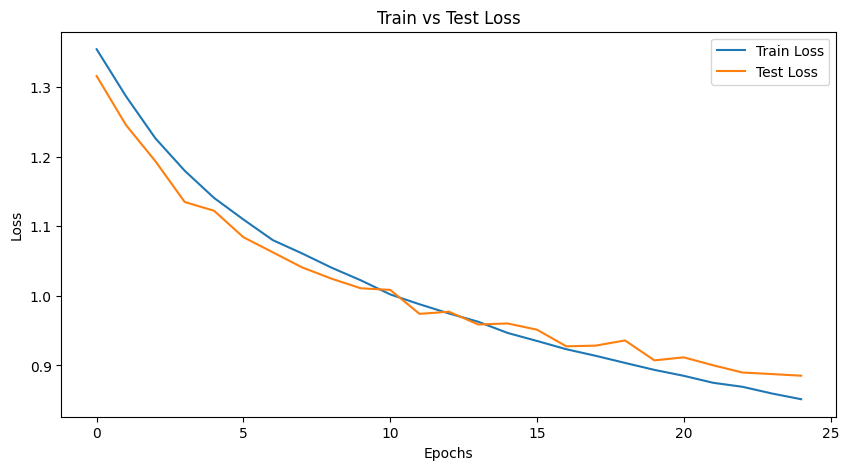

In [24]:
# Test Sonuçları ve Görselleştirme
def plot_results(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.show()

plot_results(train_losses, test_losses)